# Importing Dependencies

In [1]:
import torch
import time
from torchvision import datasets, transforms, models 
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns

# Transform Functions 


In [2]:
transform4 = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.RandomRotation(30), #+-30 degrees 
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
# Randomly crops a portion of the image and resizes it back to 224×224.
# The scale=(0.8, 1.0) means the crop will be between 80% and 100% of the original area.
# Introduces scale and aspect ratio variations, improving robustness.
    transforms.RandomHorizontalFlip(),# 50% probability to flip the image 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), #percent changes not probability 
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.2),
    transforms.ToTensor(),# converts the image to a pytorch tensor (sata type for pytorch)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # MobileNet-specific
                        # (input- mean)/ std 
])


transform3 = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize first (required for some augmentations)
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), shear=5),  # Spatial augmentations
                            # rotates the image randomly by 10 deg; Randomly shifts the image horizontally and vertically by up to 5% of its width/height.
                            # tilts the image by +-5 degrees
    transforms.ColorJitter(hue=0.05, saturation=0.05),  # Color augmentations
    transforms.RandomHorizontalFlip(),  # Flip augmentation
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=7)], p=0.2),  # Optional blur
    transforms.ToTensor(),  # Convert to tensor (normalized to [0, 1])
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet stats
])

vgg_mean = [0.485, 0.456, 0.406]
vgg_std = [0.229, 0.224, 0.225]
transform2 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),  # Reduced from 15°
    transforms.ColorJitter(brightness=0.15, contrast=0.15),  # Reduced variation
    transforms.ToTensor(),
    transforms.Normalize(mean=vgg_mean, std=vgg_std)
])


# Importing Dataset

In [3]:
dataset_vgg=datasets.ImageFolder("/kaggle/input/mepco-tropic-leaf/MepcoTropicLeaf-V1/Database", transform=transform2)
dataset_resnet=datasets.ImageFolder("/kaggle/input/mepco-tropic-leaf/MepcoTropicLeaf-V1/Database", transform=transform3)
dataset_mobilenet=datasets.ImageFolder("/kaggle/input/mepco-tropic-leaf/MepcoTropicLeaf-V1/Database", transform=transform4)

# Visualizing the Augmentations

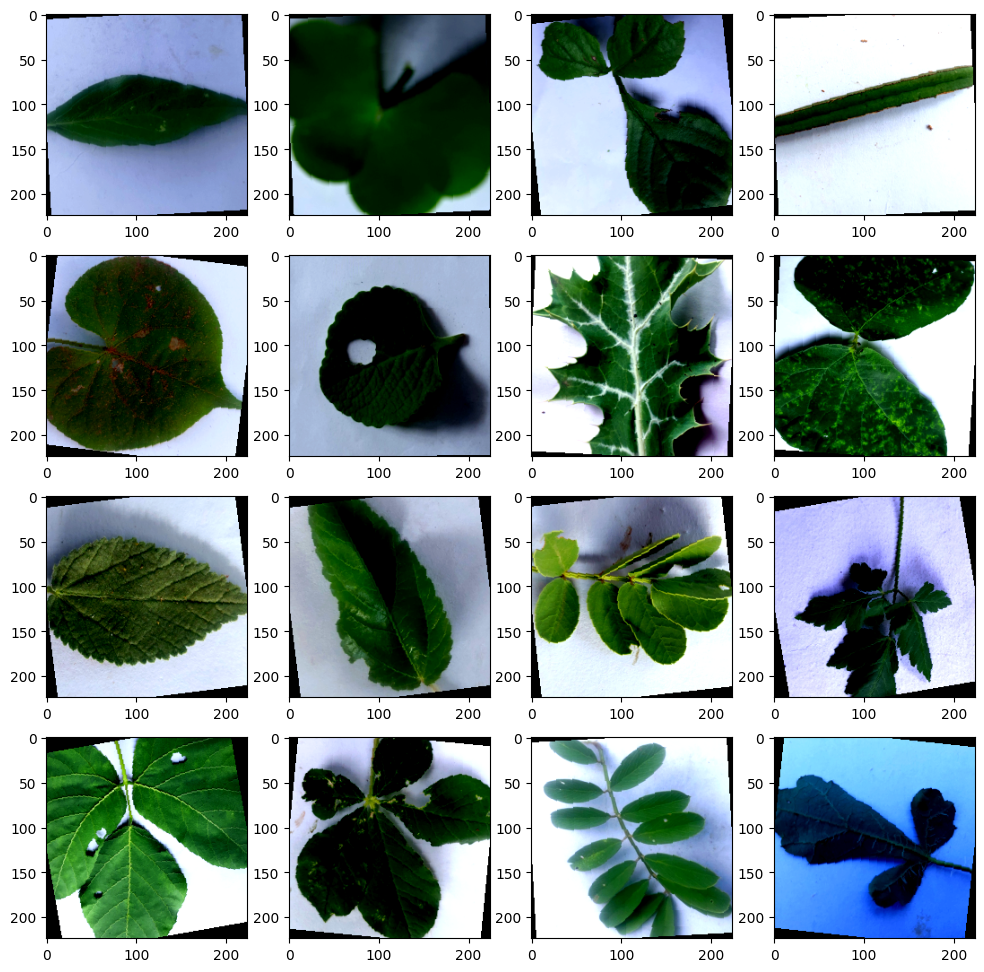

In [4]:
# Visualize augmented samples
temp_loader = torch.utils.data.DataLoader(dataset_vgg, batch_size=16, shuffle=True)
images, _ = next(iter(temp_loader))
plt.figure(figsize=(12,12))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i].permute(1,2,0).numpy()*0.5+0.5)  # Un-normalize
plt.show()

# Splitting the dataset

## VGG

In [5]:
indices_vgg=list(range(len(dataset_vgg))) # dataset ko numerate karne ke liye
split_vgg=int(np.floor(0.70*len(dataset_vgg)))
validation_vgg=int(np.floor(0.60*split_vgg))

# agar tmre pass 100 samples hai
# toh split=70(ie 70% of the dataset)-> ee use hoga training and validation ke liye; remaining (30)30% used hoga as test set
# tb validation=42 (ie 60% of the dataset)-> ee use hoga for training ke liye; remaining (28)40% used hoga as Validation set
# toh phir training= 42%; validation= 28%; test=30%
print("VGG")
print(f"length of train size : {validation_vgg}")
print(f"length of validation size : {split_vgg-validation_vgg}")
print(f"length of test size : {len(dataset_vgg)-split_vgg}")

np.random.shuffle(indices_vgg) # dataset me randomness laane ke liye

# ab actual splitting
train_indices_vgg, validation_indices_vgg, test_indices_vgg = (
    indices_vgg[:validation_vgg], # [:5]->0,1,2,3,4
    indices_vgg[validation_vgg:split_vgg],# [1:3]->1,2
    indices_vgg[split_vgg:],# [2:]-> 2,3,4,5,........
)

train_sampler_vgg = SubsetRandomSampler(train_indices_vgg)
validation_sampler_vgg = SubsetRandomSampler(validation_indices_vgg)
test_sampler_vgg = SubsetRandomSampler(test_indices_vgg)

# print(list(train_indices))
# print(list(validation_indices))
# print(list(test_indices))

# print(list(train_sampler))
# print(list(validation_sampler))
# print(list(test_sampler))


VGG
length of train size : 1585
length of validation size : 1058
length of test size : 1134


## Mobilenetv2


In [6]:
indices_mob=list(range(len(dataset_mobilenet))) # dataset ko numerate karne ke liye
split_mob=int(np.floor(0.70*len(dataset_mobilenet)))
validation_mob=int(np.floor(0.60*split_mob))

# agar tmre pass 100 samples hai
# toh split=70(ie 70% of the dataset)-> ee use hoga training and validation ke liye; remaining (30)30% used hoga as test set
# tb validation=42 (ie 60% of the dataset)-> ee use hoga for training ke liye; remaining (28)40% used hoga as Validation set
# toh phir training= 42%; validation= 28%; test=30%
print("MOBILENETv2")
print(f"length of train size : {validation_mob}")
print(f"length of validation size : {split_mob-validation_mob}")
print(f"length of test size : {len(dataset_mobilenet)-split_mob}")

np.random.shuffle(indices_mob) # dataset me randomness laane ke liye

# ab actual splitting
train_indices_mob, validation_indices_mob, test_indices_mob = (
    indices_mob[:validation_mob], # [:5]->0,1,2,3,4
    indices_mob[validation_mob:split_mob],# [1:3]->1,2
    indices_mob[split_mob:],# [2:]-> 2,3,4,5,........
)

train_sampler_mob = SubsetRandomSampler(train_indices_mob)
validation_sampler_mob = SubsetRandomSampler(validation_indices_mob)
test_sampler_mob = SubsetRandomSampler(test_indices_mob)

# print(list(train_indices))
# print(list(validation_indices))
# print(list(test_indices))

# print(list(train_sampler))
# print(list(validation_sampler))
# print(list(test_sampler))


MOBILENETv2
length of train size : 1585
length of validation size : 1058
length of test size : 1134


## RESNET18


In [7]:
indices_res=list(range(len(dataset_resnet))) # dataset ko numerate karne ke liye
split_res=int(np.floor(0.70*len(dataset_resnet)))
validation_res=int(np.floor(0.60*split_res))

# agar tmre pass 100 samples hai
# toh split=70(ie 70% of the dataset)-> ee use hoga training and validation ke liye; remaining (30)30% used hoga as test set
# tb validation=42 (ie 60% of the dataset)-> ee use hoga for training ke liye; remaining (28)40% used hoga as Validation set
# toh phir training= 42%; validation= 28%; test=30%
print("RESNET18")
print(f"length of train size : {validation_res}")
print(f"length of validation size : {split_res-validation_res}")
print(f"length of test size : {len(dataset_resnet)-split_res}")

np.random.shuffle(indices_res) # dataset me randomness laane ke liye

# ab actual splitting
train_indices_res, validation_indices_res, test_indices_res = (
    indices_res[:validation_res], # [:5]->0,1,2,3,4
    indices_res[validation_res:split_res],# [1:3]->1,2
    indices_res[split_res:],# [2:]-> 2,3,4,5,........
)

train_sampler_res = SubsetRandomSampler(train_indices_res)
validation_sampler_res = SubsetRandomSampler(validation_indices_res)
test_sampler_res = SubsetRandomSampler(test_indices_res)

# print(list(train_indices))
# print(list(validation_indices))
# print(list(test_indices))

# print(list(train_sampler))
# print(list(validation_sampler))
# print(list(test_sampler))


RESNET18
length of train size : 1585
length of validation size : 1058
length of test size : 1134


# Number of unique classes in the dataset

In [8]:
targets_size = len(dataset_resnet.class_to_idx)# finding the total unique classes and storing it
print(targets_size)
print(list(dataset_resnet.class_to_idx.keys()))
num_classes_list = list(dataset_resnet.class_to_idx.values())# now numerating them
print(num_classes_list)

50
['Asthma Plant.zip', 'Avaram.zip', 'Balloon vine.zip', 'Bellyache bush (Green).zip', 'Benghal dayflower.zip', 'Big Caltrops.zip', 'Black-Honey Shrub.zip', 'Bristly Wild Grape.zip', 'Butterfly Pea.zip', 'Cape Gooseberry.zip', 'Common Wireweed.zip', 'Country Mallow.zip', 'Crown flower.zip', 'Green Chireta.zip', 'Holy Basil.zip', 'Indian CopperLeaf.zip', 'Indian Jujube.zip', 'Indian Sarsaparilla.zip', 'Indian Stinging Nettle.zip', 'Indian Thornapple.zip', 'Indian wormwood.zip', 'Ivy Gourd.zip', 'Kokilaksha.zip', 'Land Caltrops (Bindii).zip', 'Madagascar Periwinkle.zip', 'Madras Pea Pumpkin.zip', 'Malabar Catmint.zip', 'Mexican Mint.zip', 'Mexican Prickly Poppy.zip', 'Mountain Knotgrass.zip', 'Nalta Jute.zip', 'Night blooming Cereus.zip', 'Panicled Foldwing.zip', 'Prickly Chaff Flower.zip', 'Punarnava.zip', 'Purple Fruited Pea Eggplant.zip', 'Purple Tephrosia.zip', 'Rosary Pea.zip', 'Shaggy button weed.zip', 'Small Water Clover.zip', 'Spiderwisp.zip', 'Square Stalked Vine.zip', 'Stinkin

# Loading the models

## MOBILENETV2

In [9]:
model2 = models.mobilenet_v2(pretrained=True)
    
# Freeze all layers first
for param in model2.parameters():
    param.requires_grad = False
    
  
for layer in model2.features[-6:]:  # Last 6 layers
    for param in layer.parameters():
        param.requires_grad = True
    
    # Modify classifier
model2.classifier[1] = nn.Linear(model2.classifier[1].in_features, targets_size)
model2.classifier[0] = nn.Dropout(p=0.3)  
    
model2.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model2.classifier[1].in_features, 512),  # Hidden layer
    nn.ReLU(),
    nn.Linear(512, targets_size)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 114MB/s] 


## RESNET18

In [10]:
model = models.resnet18(pretrained=True)
# model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s] 


## VGG16

In [11]:
# Replace your model loading with this:
model3 = models.vgg16(pretrained=True)

# Freeze early layers (keep BatchNorm trainable)
for name, param in model3.named_parameters():
    if 'features' in name and 'weight' in name:  # Freeze only conv weights
        param.requires_grad = False

model3.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.6),  # Reduced from 0.7
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.6),  # Reduced from 0.7
    nn.Linear(4096, 50)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 203MB/s]  


# Extracting Feature Size 

In [13]:
# n_features_res = model.conv1.in_channels #resnet18; number of input features in the first convolutional layer
# n_features_res
# n_features_vgg = model3.classifier[0].in_features #vgg16; number of input features in the first fully connected layer
# n_features_vgg
# n_features_mob = model2.classifier[1].in_features #mobilenet; number of input features in the first fully connected layer
# n_features_mob

3

# Overriding the computation to GPU (if available)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) #checking if GPU is available
model2.to(device)
model.to(device)
model3.to(device)

cuda


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Loss Function and Optimizer

## Loss Function



In [16]:
criterion = nn.CrossEntropyLoss() # calculates the loss during training, which will be later used by backpropagation to imporove the models accuracy

## Optimizer


### For Mobilenetv2

In [17]:
optimizer_mob = torch.optim.Adam([
    {'params': model2.features[-6:].parameters(), 'lr': 1e-4},  # for feature part of the last 6 layers  
    {'params': model2.classifier.parameters(), 'lr': 1e-3}       #for classifier part of the model 
], weight_decay=1e-5)  # Reduce weight decay #Add to the optimizer to penalize large weights

#adam optimiser is used to optimise the models parameters(weights of the model) to minimise the loss and hence increase the accuracy

### For RESNET18

In [19]:
optimizer_res = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
#adam optimiser is used to optimise the models parameters(weights of the model) to minimise the loss and hence increase the accuracy

### For VGG16


In [20]:
optimizer_vgg = torch.optim.Adam(model3.parameters(), lr=0.0001, weight_decay=5e-5)  # Reduced L2
#adam optimiser is used to optimise the models parameters(weights of the model) to minimise the loss and hence increase the accuracy

# Dividing the dataset into train, test, validation batches


In [21]:
batch_size = 64
#mobilnet
train_loader_mob = torch.utils.data.DataLoader(
    dataset_mobilenet, batch_size=batch_size, sampler=train_sampler_mob 
)
validation_loader_mob = torch.utils.data.DataLoader(
    dataset_mobilenet, batch_size=batch_size, sampler=validation_sampler_mob
)
test_loader_mob = torch.utils.data.DataLoader(
    dataset_mobilenet, batch_size=batch_size, sampler=test_sampler_mob
)
#resnet
train_loader_res = torch.utils.data.DataLoader(
    dataset_resnet, batch_size=batch_size, sampler=train_sampler_res
)
test_loader_res = torch.utils.data.DataLoader(
    dataset_resnet, batch_size=batch_size, sampler=test_sampler_res
)
validation_loader_res = torch.utils.data.DataLoader(
    dataset_resnet, batch_size=batch_size, sampler=validation_sampler_res
)
#vgg
train_loader_vgg = torch.utils.data.DataLoader(
    dataset_vgg, batch_size=batch_size, sampler=train_sampler_vgg
)
test_loader_vgg = torch.utils.data.DataLoader(
    dataset_vgg, batch_size=batch_size, sampler=test_sampler_vgg
)
validation_loader_vgg = torch.utils.data.DataLoader(
    dataset_vgg, batch_size=batch_size, sampler=validation_sampler_vgg
)

# Plot Function 

In [22]:
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(test_losses, label='Validation Loss', color='red', marker='x')
    plt.title('Training and Validation Losses', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Gradient Descent



In [23]:
def batch_gd_new(used_model, criterion, train_loader, test_loader, epochs, used_optimizer):
    train_losses = np.zeros(epochs) # initializes a numpy array with '0' 
    test_losses = np.zeros(epochs)
    
    # Memory tracking initialization
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        mem_before = torch.cuda.memory_allocated() / 1024**2  # converted to MB from bytes 
    
    # Track average inference time
    total_inference_time = 0
    inference_count = 0
    
    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        # Training phase (forward pass)
        for inputs, targets in train_loader: #inputs- actual input; target- actual labels 
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Measure inference time
            start_time = time.time()
            used_optimizer.zero_grad()# resets the gradients to '0'. ONLY FOR TRAINING PHASE
            output = used_model(inputs) #output- actual predicted output; passed through the model
            inference_time = time.time() - start_time # inference time- time taken to make the predictions
            
            total_inference_time += inference_time
            inference_count += 1
            
            loss = criterion(output, targets) # calculates the loss of the preidctions
            train_loss.append(loss.item()) #appends the current training loss value to the NP array; .item()-> tensor to python float 
            loss.backward() # performs backward pass (ie recalculates the gradients based on the losses)
            used_optimizer.step() # updates the weights calculated previously

        train_loss = np.mean(train_loss) # avg training loss for current epoch 
        test_loss = []
        
        # Validation phase
        used_model.eval() # no gradients will be calculated during this phase
        with torch.no_grad(): # no_grad-> resets the gradients to '0'. ONLY FOR VALIDATION PHASE
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                output = used_model(inputs)
                loss = criterion(output, targets)
                test_loss.append(loss.item()) #appends the current testing loss value to the NP array; .item()-> tensor to python float 
        used_model.train()# this is the default mode; changing it back to training phase so that in next epoch it can update the weights 

        test_loss = np.mean(test_loss)
        train_losses[e] = train_loss
        test_losses[e] = test_loss
        
        dt = datetime.now() - t0
        print(f"Epoch {e+1}/{epochs} Train loss: {train_loss:.4f} Val loss: {test_loss:.4f} Duration: {dt}")

    # Memory and timing results
    avg_inference_time = total_inference_time / inference_count if inference_count > 0 else 0
    print(f"\nTraining Summary:")
    print(f"Average inference time per batch: {avg_inference_time:.4f} seconds")
    
    if torch.cuda.is_available():
        mem_after = torch.cuda.memory_allocated() / 1024**2
        mem_used = mem_after - mem_before
        print(f"GPU Memory used: {mem_used:.2f} MB")
    print(f"Max GPU Memory Allocated: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")
    
    return train_losses, test_losses

## Running the Gradient Descent


Mobilenetv2
Epoch 1/10 Train loss: 3.1597 Val loss: 2.0936 Duration: 0:01:29.155771
Epoch 2/10 Train loss: 1.2964 Val loss: 0.9426 Duration: 0:01:07.874112
Epoch 3/10 Train loss: 0.6014 Val loss: 0.4799 Duration: 0:01:06.991887
Epoch 4/10 Train loss: 0.3444 Val loss: 0.3759 Duration: 0:01:06.412555
Epoch 5/10 Train loss: 0.2277 Val loss: 0.2966 Duration: 0:01:05.821068
Epoch 6/10 Train loss: 0.1863 Val loss: 0.2682 Duration: 0:01:05.433242
Epoch 7/10 Train loss: 0.1504 Val loss: 0.2722 Duration: 0:01:05.484975
Epoch 8/10 Train loss: 0.1179 Val loss: 0.2688 Duration: 0:01:05.081275
Epoch 9/10 Train loss: 0.1206 Val loss: 0.2583 Duration: 0:01:05.442914
Epoch 10/10 Train loss: 0.1037 Val loss: 0.2504 Duration: 0:01:05.295898

Training Summary:
Average inference time per batch: 0.0130 seconds
GPU Memory used: 66.49 MB
Max GPU Memory Allocated: 1289.65 MB


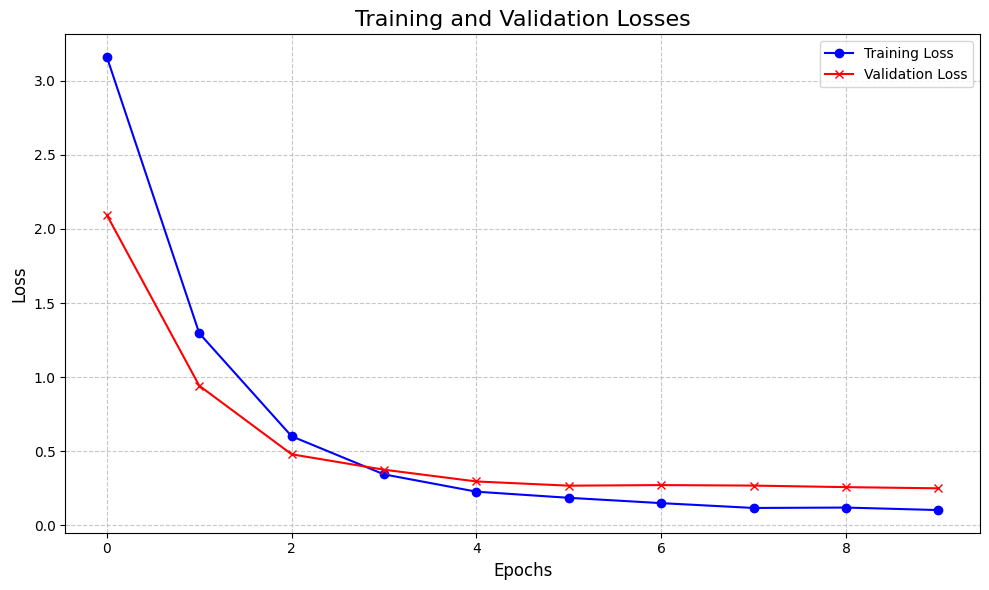

In [24]:
print("Mobilenetv2")
train_losses, test_losses= batch_gd_new(model2, criterion, train_loader_mob, validation_loader_mob, 10, optimizer_mob)
plot_losses(train_losses, test_losses)

Resnet18
Epoch 1/10 Train loss: 5.3719 Val loss: 2.9996 Duration: 0:01:23.454775
Epoch 2/10 Train loss: 1.2367 Val loss: 0.8691 Duration: 0:01:18.379540
Epoch 3/10 Train loss: 0.3986 Val loss: 0.4840 Duration: 0:01:17.861960
Epoch 4/10 Train loss: 0.1878 Val loss: 0.3907 Duration: 0:01:16.215360
Epoch 5/10 Train loss: 0.1013 Val loss: 0.3099 Duration: 0:01:16.603373
Epoch 6/10 Train loss: 0.0742 Val loss: 0.2911 Duration: 0:01:16.048225
Epoch 7/10 Train loss: 0.0514 Val loss: 0.2688 Duration: 0:01:16.000406
Epoch 8/10 Train loss: 0.0383 Val loss: 0.2298 Duration: 0:01:16.913612
Epoch 9/10 Train loss: 0.0304 Val loss: 0.2415 Duration: 0:01:16.424466
Epoch 10/10 Train loss: 0.0254 Val loss: 0.2232 Duration: 0:01:15.625073

Training Summary:
Average inference time per batch: 0.0053 seconds
GPU Memory used: 170.17 MB
Max GPU Memory Allocated: 3306.50 MB


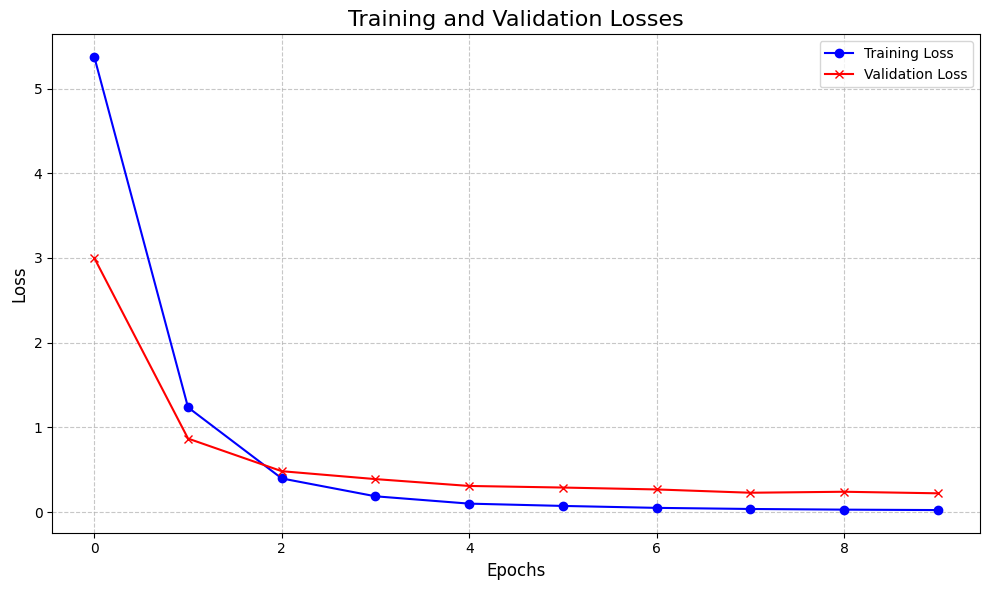

In [25]:
print("Resnet18")
train_losses, test_losses= batch_gd_new(model, criterion, train_loader_res, validation_loader_res, 10, optimizer_res)
plot_losses(train_losses, test_losses)

VGG16
Epoch 1/20 Train loss: 3.7607 Val loss: 3.3892 Duration: 0:01:05.836825
Epoch 2/20 Train loss: 3.1339 Val loss: 2.5797 Duration: 0:01:02.635369
Epoch 3/20 Train loss: 2.2341 Val loss: 1.7486 Duration: 0:01:02.782235
Epoch 4/20 Train loss: 1.5735 Val loss: 1.2145 Duration: 0:01:03.973835
Epoch 5/20 Train loss: 1.1200 Val loss: 0.9816 Duration: 0:01:04.138356
Epoch 6/20 Train loss: 0.7969 Val loss: 0.8099 Duration: 0:01:03.592136
Epoch 7/20 Train loss: 0.5862 Val loss: 0.6802 Duration: 0:01:03.362603
Epoch 8/20 Train loss: 0.4681 Val loss: 0.6204 Duration: 0:01:03.322827
Epoch 9/20 Train loss: 0.3672 Val loss: 0.5623 Duration: 0:01:02.860480
Epoch 10/20 Train loss: 0.2867 Val loss: 0.5476 Duration: 0:01:02.909249
Epoch 11/20 Train loss: 0.2285 Val loss: 0.5228 Duration: 0:01:02.853823
Epoch 12/20 Train loss: 0.1843 Val loss: 0.4601 Duration: 0:01:03.154712
Epoch 13/20 Train loss: 0.1549 Val loss: 0.4545 Duration: 0:01:03.238014
Epoch 14/20 Train loss: 0.1422 Val loss: 0.4148 Durati

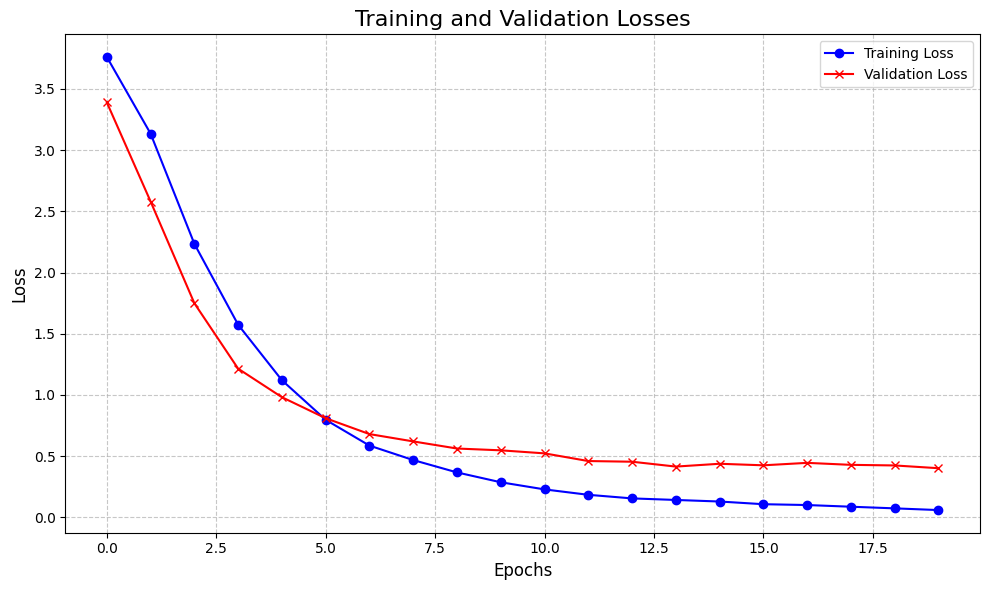

In [26]:
print("VGG16")
train_losses, test_losses= batch_gd_new(model3, criterion, train_loader_vgg, validation_loader_vgg, 20, optimizer_vgg)
plot_losses(train_losses, test_losses)

# Top-1 accuracy scores 

In [27]:
def accuracy(loader,used_model):
    n_correct = 0
    n_total = 0
    used_model.cuda()
    for inputs, targets in loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = used_model(inputs)
        #print(outputs)
        _, predictions = torch.max(outputs, 1) # max() returns 2 param we ignore the first one thats why _ 
        # The first is a tensor of maximum values for each sample in the batch, this contains the highest score for each sample.(not required for calculating the accuracy)
        # The second is a tensor of the indices of these maximum values. This is the class index with the highest score for each sample.
        # each tensor is a m*n matrix; here we use the '1' in torch.max so that it returns the class index for each row (which will be the predicted value)
        n_correct += (predictions == targets).sum().item() #.item -> tensor to numpy array 
        n_total += targets.shape[0] # tagets.shape[0] contains the batch size

    acc = n_correct / n_total
    return acc

In [28]:
train_acc_mob = accuracy(train_loader_mob, model2)
test_acc_mob = accuracy(test_loader_mob,model2)
validation_acc_mob = accuracy(validation_loader_mob,model2)

print(f"MOBILENETV2 Train Accuracy : {train_acc_mob}\nTest Accuracy : {test_acc_mob}\nValidation Accuracy : {validation_acc_mob}\n")

MOBILENETV2 Train Accuracy : 0.9804416403785489
Test Accuracy : 0.9206349206349206
Validation Accuracy : 0.9168241965973535



In [29]:
train_acc_res = accuracy(train_loader_res, model)
test_acc_res = accuracy(test_loader_res,model)
validation_acc_res = accuracy(validation_loader_res,model)

print(f"RESNET18 Train Accuracy : {train_acc_res}\nTest Accuracy : {test_acc_res}\nValidation Accuracy : {validation_acc_res}\n")

RESNET18 Train Accuracy : 0.9987381703470032
Test Accuracy : 0.9514991181657848
Validation Accuracy : 0.9395085066162571



In [30]:
train_acc_vgg = accuracy(train_loader_vgg, model3)
test_acc_vgg= accuracy(test_loader_vgg,model3)
validation_acc_vgg = accuracy(validation_loader_vgg ,model3)

print(f"VGG16 Train Accuracy : {train_acc_vgg}\nTest Accuracy : {test_acc_vgg}\nValidation Accuracy : {validation_acc_vgg}")

VGG16 Train Accuracy : 0.9892744479495268
Test Accuracy : 0.8386243386243386
Validation Accuracy : 0.8449905482041588


# Plotting accuracies of each model

In [32]:
def get_predictions(loader, models):
    models.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad(): # disables gradient calculation (why here- we are only predicting not training)
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = models(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy()) # adds to the all_preds array while moving the predictions to cpu from gpu and converting them to numpy array 
            all_targets.extend(targets.cpu().numpy()) # adds to the all_targets array while moving the predictions to cpu from gpu and converting them to numpy array 
    
    return all_targets, all_preds

In [33]:
# Get predictions for each model
y_true_mob, y_pred_mob = get_predictions(test_loader_mob, model2)
y_true_res, y_pred_res = get_predictions(test_loader_res, model)
y_true_vgg, y_pred_vgg = get_predictions(test_loader_vgg, model3)

# Weighted-averaged metrics (accounts for class imbalance)
metrics = {
    'MobileNetV2': {
        'Precision': precision_score(y_true_mob, y_pred_mob, average='weighted'),
        'Recall': recall_score(y_true_mob, y_pred_mob, average='weighted'),
        'F1': f1_score(y_true_mob, y_pred_mob, average='weighted')
    },
    'ResNet18': {
        'Precision': precision_score(y_true_res, y_pred_res, average='weighted'), # 'average= weighted'-> for class imbalance 
        'Recall': recall_score(y_true_res, y_pred_res, average='weighted'),
        'F1': f1_score(y_true_res, y_pred_res, average='weighted')
    },
    'VGG16': {
        'Precision': precision_score(y_true_vgg, y_pred_vgg, average='weighted'),
        'Recall': recall_score(y_true_vgg, y_pred_vgg, average='weighted'),
        'F1': f1_score(y_true_vgg, y_pred_vgg, average='weighted')
    }
}

# Print results
print("\nWeighted-Averaged Metrics (Accounts for Class Imbalance):")
for model_name, scores in metrics.items():
    print(f"\n{model_name}:")
    print(f"- Precision: {scores['Precision']:.4f}")
    print(f"- Recall:    {scores['Recall']:.4f}")
    print(f"- F1-score:  {scores['F1']:.4f}")


Weighted-Averaged Metrics (Accounts for Class Imbalance):

MobileNetV2:
- Precision: 0.9382
- Recall:    0.9321
- F1-score:  0.9319

ResNet18:
- Precision: 0.9645
- Recall:    0.9621
- F1-score:  0.9619

VGG16:
- Precision: 0.9203
- Recall:    0.9127
- F1-score:  0.9128


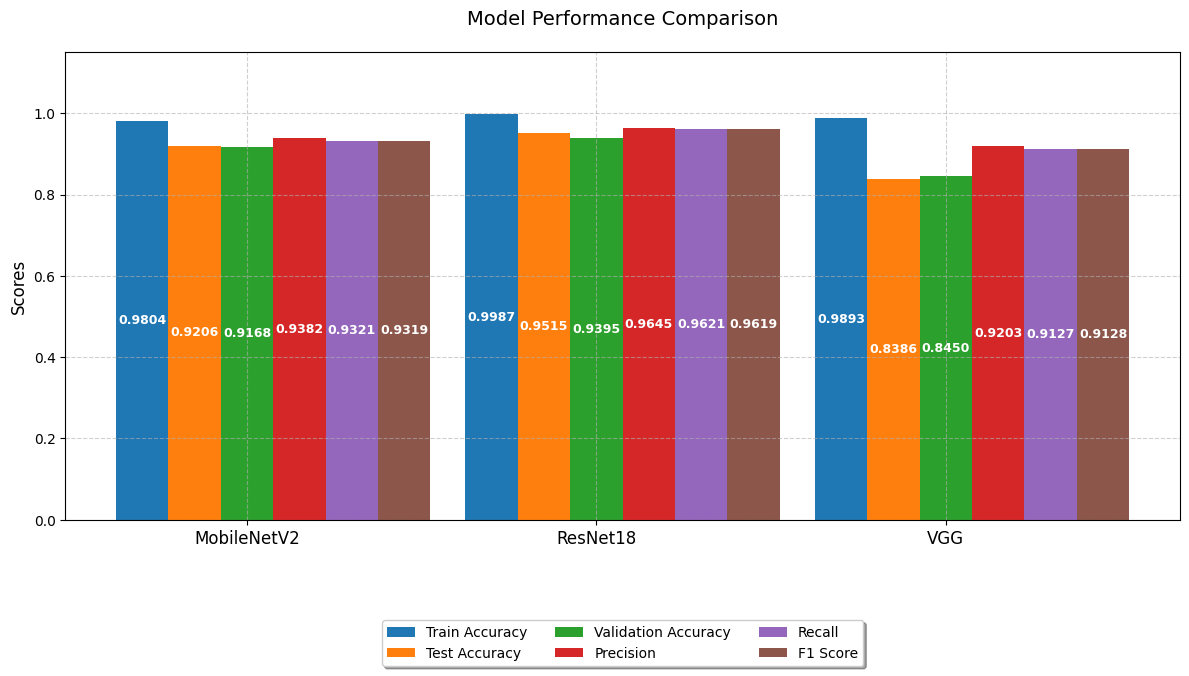

In [38]:
models = ['MobileNetV2', 'ResNet18', 'VGG']
train_acc = [train_acc_mob, train_acc_res, train_acc_vgg]
test_acc = [test_acc_mob, test_acc_res, test_acc_vgg]
val_acc = [validation_acc_mob, validation_acc_res, validation_acc_vgg]

# Extract metrics from existing dictionary with 4 decimal precision
precision_scores = [round(metrics[model]['Precision'], 4) for model in metrics]
recall_scores = [round(metrics[model]['Recall'], 4) for model in metrics]
f1_scores = [round(metrics[model]['F1'], 4) for model in metrics]

x = np.arange(len(models))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 7))
ax.grid(True, linestyle='--', alpha=0.6)  # Add grid lines

# Create bars for each metric
rects1 = ax.bar(x - width*2, train_acc, width, label='Train Accuracy', color='#1f77b4')
rects2 = ax.bar(x - width, test_acc, width, label='Test Accuracy', color='#ff7f0e')
rects3 = ax.bar(x, val_acc, width, label='Validation Accuracy', color='#2ca02c')
rects4 = ax.bar(x + width, precision_scores, width, label='Precision', color='#d62728')
rects5 = ax.bar(x + width*2, recall_scores, width, label='Recall', color='#9467bd')
rects6 = ax.bar(x + width*3, f1_scores, width, label='F1 Score', color='#8c564b')

# Formatting
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.set_ylim(0, 1.15)  # Adjusted to accommodate values

# Add values inside the bars with 4 decimal precision
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height/2,
                f'{height:.4f}',  # 4 decimal places
                ha='center', va='center',
                color='white', fontweight='bold',
                fontsize=9)

for rects in [rects1, rects2, rects3, rects4, rects5, rects6]:
    autolabel(rects)

# Legend below x-axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          ncol=3, fancybox=True, shadow=True, fontsize=10)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Adjusted for better legend spacing
plt.show()